# Calculate the number of orders per month in 2018.

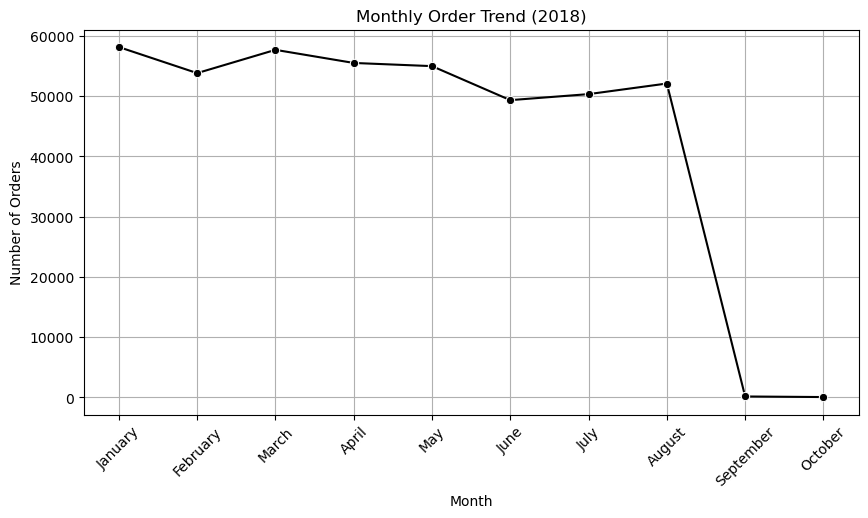

In [8]:
from SQLHelper import run_query
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

query = """SELECT DATENAME(MONTH,order_purchase_timestamp) AS Month,
COUNT(*) AS Order_Count
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY DATENAME(MONTH,order_purchase_timestamp),MONTH(order_purchase_timestamp)
ORDER BY MONTH(order_purchase_timestamp);"""

df = run_query(query)

# line chart
plt.figure(figsize=(10, 5))
sns.lineplot(x=df["Month"], y=df["Order_Count"], marker="o", color="black")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.title("Monthly Order Trend (2018)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Find the average number of products per order, grouped by customer state

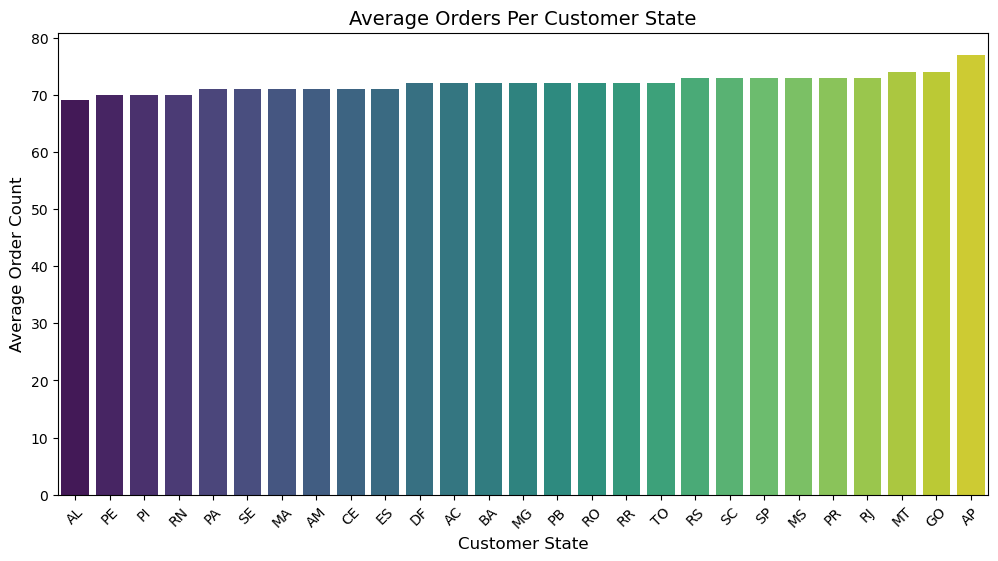

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from SQLHelper import run_query

# SQL Query
query = """
WITH COUNT_AS_PER_ORDER AS (SELECT orders.customer_id,orders.order_id, count(order_items.order_id) AS oc
FROM orders JOIN order_items ON order_items.order_id = orders.order_id
GROUP BY orders.customer_id,orders.order_id)

SELECT customers.customer_state, AVG(COUNT_AS_PER_ORDER.oc) as average
FROM customers JOIN COUNT_AS_PER_ORDER
ON customers.customer_id = COUNT_AS_PER_ORDER.customer_id
GROUP BY customers.customer_state
ORDER BY average ASC;"""

# Fetch Data
df = run_query(query)

# Seaborn Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', y='average', data=df, hue='customer_state', palette='viridis', legend=False)

# Labels and Title
plt.xlabel("Customer State", fontsize=12)
plt.ylabel("Average Order Count", fontsize=12)
plt.title("Average Orders Per Customer State", fontsize=14)
plt.xticks(rotation=45)

# Show plot
plt.show()


# Calculate the percentage of total revenue contributed by each product category

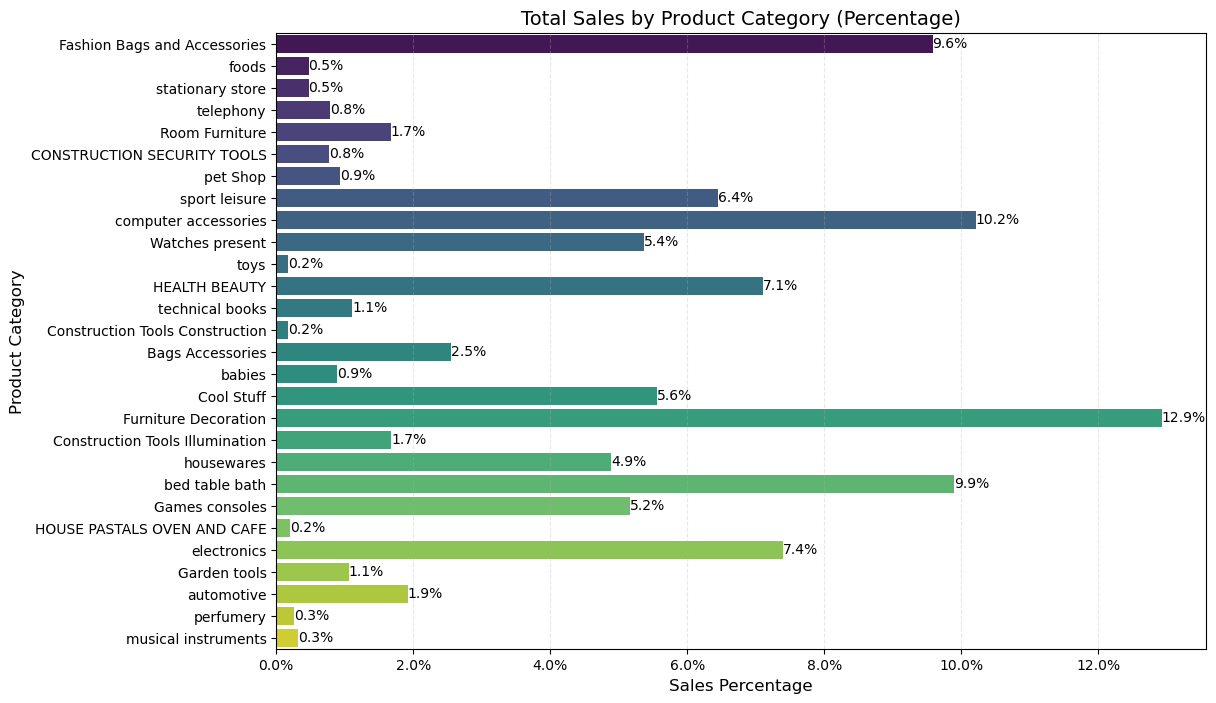

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter  # ✅ Import FuncFormatter
from SQLHelper import run_query

# SQL Query
query = """SELECT products.[product category] AS product_category, 
                  ROUND(SUM(order_items.price),2) AS total_sales
           FROM products 
           JOIN order_items ON order_items.product_id = products.product_id
           GROUP BY products.[product category];"""

# Fetch Data
df = run_query(query)

# Normalize total sales to percentage
df["sales_percentage"] = (df["total_sales"] / df["total_sales"].sum()) * 100

# Create figure
plt.figure(figsize=(12, 8))

ax = sns.barplot(y="product_category", x="sales_percentage", data=df, hue="product_category", palette="viridis", legend=False)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}%"))

for bar in ax.patches:
    ax.text(
        bar.get_width(),  # Adjust position
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.1f}%",
        va="center", ha="left", fontsize=10, color="black"
    )

plt.xlabel("Sales Percentage", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.title("Total Sales by Product Category (Percentage)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.3)

plt.show()




# Identify the correlation between product price and the number of times a product has been purchased.

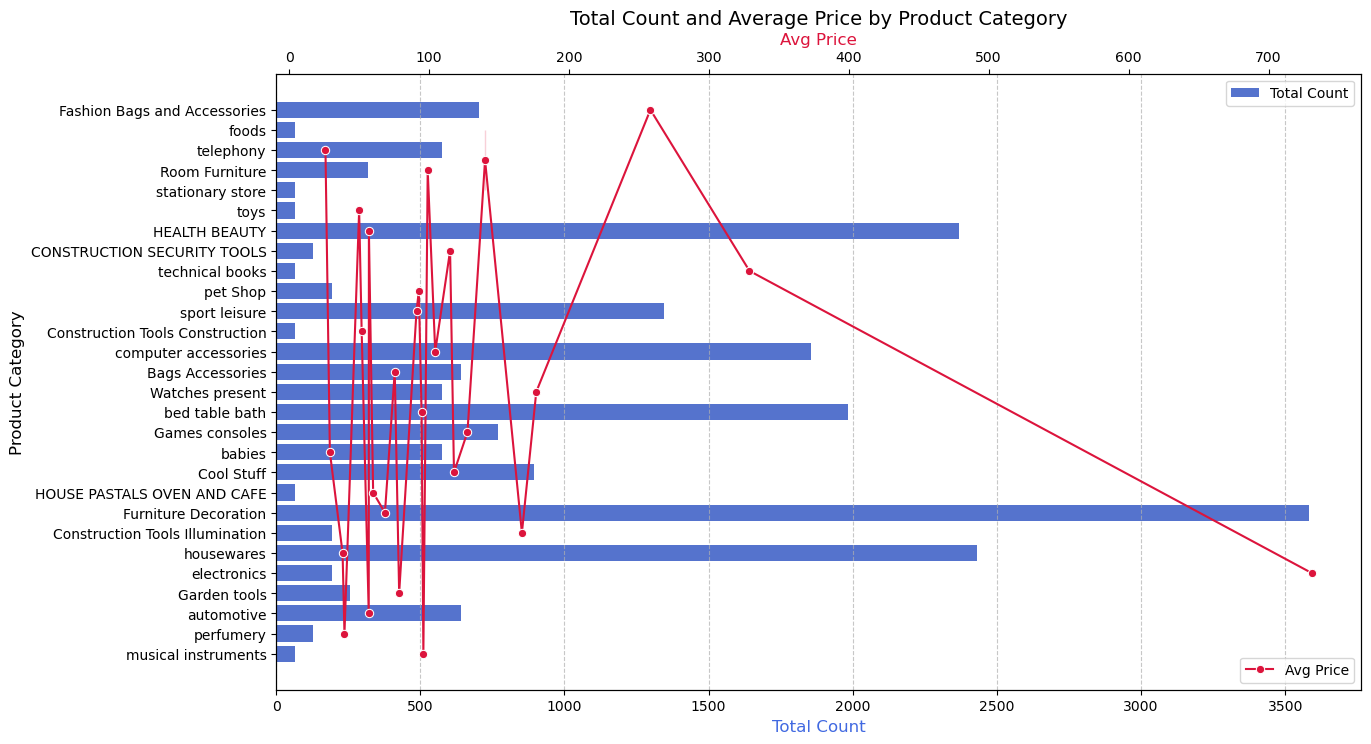

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from SQLHelper import run_query

# SQL Query
query = """SELECT products.[product category] AS product_category, 
                  COUNT(order_items.product_id) AS total_count, 
                  ROUND(AVG(order_items.price),2) AS avg_price
           FROM products 
           JOIN order_items ON order_items.product_id = products.product_id
           GROUP BY products.[product category];"""

# Fetch Data
df = run_query(query)

# Set figure size
fig, ax1 = plt.subplots(figsize=(14, 8))

# Create barplot for Total Count
sns.barplot(y=df["product_category"], x=df["total_count"], color="royalblue", label="Total Count", ax=ax1)

# Create second axis for Average Price
ax2 = ax1.twiny()
sns.lineplot(y=df["product_category"], x=df["avg_price"], color="crimson", marker="o", label="Avg Price", ax=ax2)

# Labels & Titles
ax1.set_xlabel("Total Count", fontsize=12, color="royalblue")
ax2.set_xlabel("Avg Price", fontsize=12, color="crimson")
ax1.set_ylabel("Product Category", fontsize=12)
plt.title("Total Count and Average Price by Product Category", fontsize=14)

# Show Legends
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")

# Grid for better readability
ax1.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()


# Calculate the total revenue generated by each seller, and rank them by revenue.

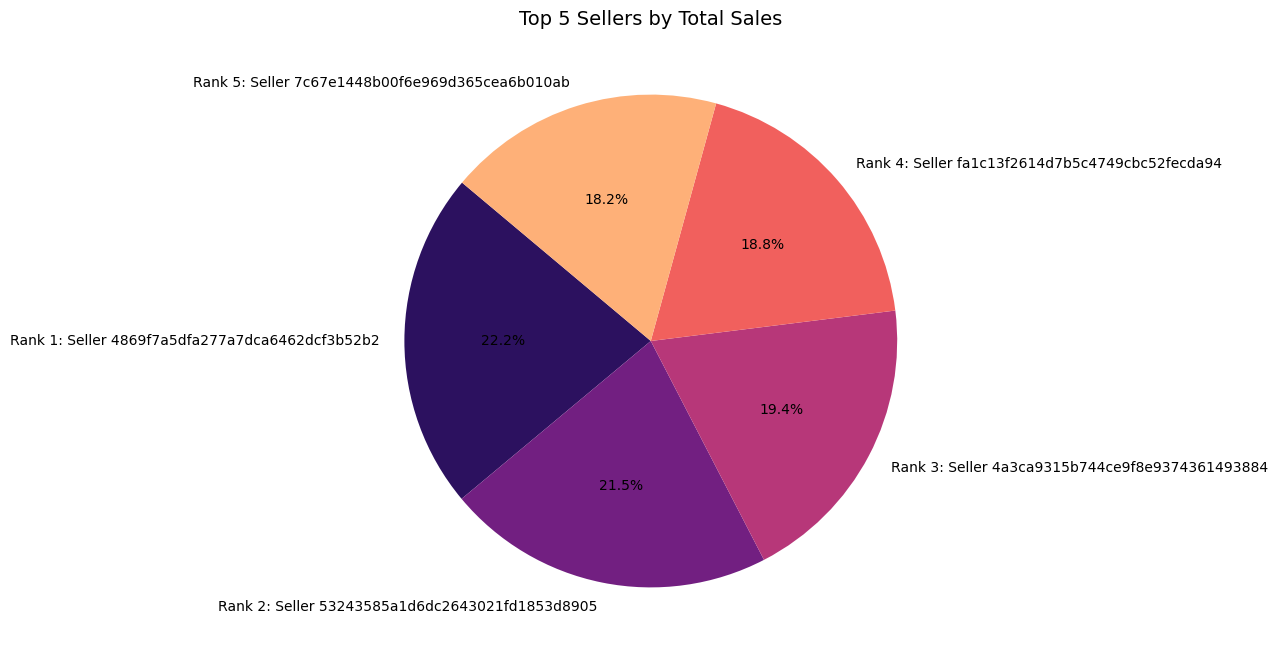

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from SQLHelper import run_query

# SQL Query
query = """WITH Ranked_Sellers AS (
    SELECT 
        order_items.seller_id, 
        ROUND(SUM(order_items.price), 2) AS total_sales,
        DENSE_RANK() OVER (ORDER BY SUM(order_items.price) DESC) AS sales_rank
    FROM order_items 
    JOIN sellers ON sellers.seller_id = order_items.seller_id
    GROUP BY order_items.seller_id
)
SELECT seller_id, total_sales, sales_rank 
FROM Ranked_Sellers
WHERE sales_rank <= 5;"""

# Fetch Data
df = run_query(query)

# Create pie chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette("magma", len(df))
plt.pie(df["total_sales"], labels=[f"Rank {r}: Seller {s}" for r, s in zip(df["sales_rank"], df["seller_id"])], 
        autopct="%1.1f%%", colors=colors, startangle=140)

# Title
plt.title("Top 5 Sellers by Total Sales", fontsize=14)
plt.show()